In [44]:
import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
# Impostiamo un seed per la riproducibilità
np.random.seed(42)

df = pd.read_csv('ordini_cleaned.csv')
df['Data_mat'] = pd.to_datetime(df['Data_mat'])
df = df.drop(['Data_ricarica','Unnamed: 0.1','Unnamed: 0','C_CLI','Nominativo'],axis = 1)

C:\Users\antonio.proietti\AppData\Local\Temp\ipykernel_18376\323874337.py:11: DtypeWarning: Columns (2,7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('ordini_cleaned.csv')


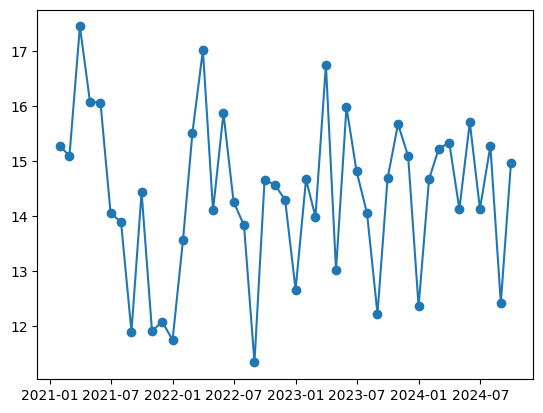

In [45]:
df_grouped = df.groupby('Data_mat').mean('Qt').reset_index()
plt.plot(df_grouped['Data_mat'],df_grouped['Qt'],marker = 'o')
plt.xlabel = 'Periodo'
plt.ylabel = 'media quantità'
plt.show()


In [46]:
df  = df.reset_index()

In [47]:
df['Qt_lag1'] = df['Qt'].shift(1)
df['Media_Mobile'] = df['Qt'].rolling(window=3).mean()

# Rimuovi le righe con valori NaN
df.dropna(inplace=True)

In [48]:
col_names = ['Azieda', 'SEDE_DI_LAVORO','CID','Valore']
for i in col_names:
    df[i] = df[i].astype(str)

<Figure size 1200x600 with 0 Axes>

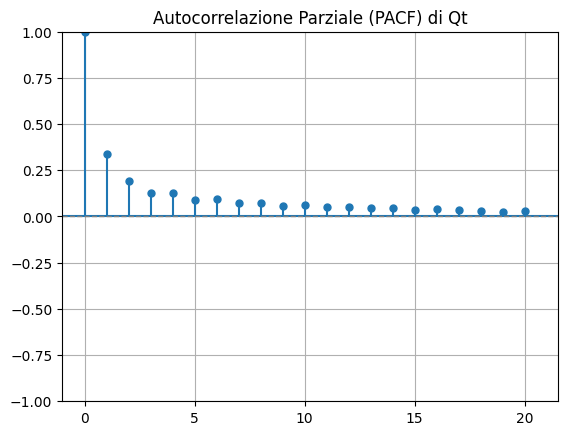

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf


plt.figure(figsize=(12, 6))
plot_pacf(df['Qt'], lags=20, alpha=0.05)
plt.title('Autocorrelazione Parziale (PACF) di Qt')

plt.axhline(0, color='gray', linestyle='--', lw=1)
plt.grid()
plt.show()


In [50]:
df.columns

Index(['index', 'Azieda', 'CID', 'Qt', 'Valore', 'Data_mat', 'SEDE_DI_LAVORO',
       'Qt_lag1', 'Media_Mobile'],
      dtype='object')

In [51]:
# Aggregazione dei dati per mese
df.set_index('Data_mat', inplace=True)

In [52]:
df.head()

,index,Azieda,CID,Qt,Valore,SEDE_DI_LAVORO,Qt_lag1,Media_Mobile
Data_mat,,,,,,,,
2023-10-31,2,A2A AIRPORT ENERGY SPA,64801,17,900,MALPENSA - AEROPORTO,19.0,18.666667
2023-10-31,3,A2A AIRPORT ENERGY SPA,64802,1,700,MALPENSA - AEROPORTO,17.0,12.333333
2023-10-31,4,A2A AIRPORT ENERGY SPA,64802,18,900,MALPENSA - AEROPORTO,1.0,12.000000
2023-10-31,5,A2A AIRPORT ENERGY SPA,64803,21,900,MALPENSA - AEROPORTO,18.0,13.333333
2023-10-31,6,A2A AIRPORT ENERGY SPA,64804,20,900,MALPENSA - AEROPORTO,21.0,19.666667


In [53]:
df = df.sort_index(ascending = True)

In [69]:
# Suddivisione in set di addestramento e di test
split_point = int(len(df)*0.8)
train = df[:split_point]
test = df[split_point:]

In [72]:
y_train = train['Qt']
y_test = test['Qt']

In [70]:
from category_encoders import TargetEncoder

encoder = TargetEncoder(cols = col_names)
# Creiamo un DataFrame con le variabili codificate
train_encoded = encoder.fit_transform(train[col_names], train['Qt'])

test_encoded = encoder.transform(test[col_names])
# Visualizza il DataFrame codificato
print(train_encoded.head())

               Azieda  SEDE_DI_LAVORO        CID     Valore
Data_mat                                                   
2021-01-31  19.060891       15.151899  19.690343  18.131194
2021-01-31  16.306758       14.195931   9.210424  18.131194
2021-01-31  16.306758       14.195931   9.210424  12.906623
2021-01-31  16.306758       10.996864   7.861124  18.131194
2021-01-31  16.306758       10.996864   6.869598  18.131194


In [73]:
train_encoded['Qt'] = y_train.values
test_encoded['Qt'] = y_test.values

In [74]:
train_encoded.head()

,Azieda,SEDE_DI_LAVORO,CID,Valore,Qt
Data_mat,,,,,
2021-01-31,19.060891,15.151899,19.690343,18.131194,25
2021-01-31,16.306758,14.195931,9.210424,18.131194,1
2021-01-31,16.306758,14.195931,9.210424,12.906623,18
2021-01-31,16.306758,10.996864,7.861124,18.131194,19
2021-01-31,16.306758,10.996864,6.869598,18.131194,17


In [75]:
train_monthly_agg = train_encoded.resample('M').agg({
    'Qt': 'mean', 
})

test_monthly_agg = test_encoded.resample('M').agg({
    'Qt': 'mean', 
})

In [76]:
for col in col_names:  # dove col_names è la lista delle colonne codificate
    train_monthly_agg[col] = train_encoded[col].resample('M').mean()
    test_monthly_agg[col] = test_encoded[col].resample('M').mean()

In [77]:
import xgboost as xgb

# Separazione delle variabili indipendenti dalla variabile target
X_train = train_monthly_agg.drop(columns=['Qt'])
y_train = train_monthly_agg['Qt']
X_test = test_monthly_agg.drop(columns=['Qt'])
y_test = test_monthly_agg['Qt']


In [78]:

# Creazione del DMatrix per XGBoost
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# Impostazione dei parametri del modello
params = {
    'objective': 'reg:squarederror',  # Obiettivo di regressione per MAE
    'max_depth': 6,                        # Profondità massima degli alberi
    'learning_rate': 0.1,                  # Tasso di apprendimento
    'n_estimators': 100,                   # Numero di alberi
    'seed': 42
}


In [79]:

# Allenamento del modello
model = xgb.train(params, dtrain, num_boost_round=100)

# Previsione
predictions = model.predict(dtest)

# Calcolo delle metriche di performance
mae = mean_absolute_error(y_test, predictions)

print(f'MAE: {mae:.2f}')

MAE: 1.95


c:\Users\antonio.proietti\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\core.py:158: UserWarning: [17:27:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0ed59c031377d09b8-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "n_estimators" } are not used.

  warnings.warn(smsg, UserWarning)


In [80]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Previsioni del modello XGBoost
xgb_predictions = model.predict(dtest)  # Assicurati di avere il tuo X_test correttamente definito

# Calcolo delle metriche
xgb_rmse = mean_squared_error(y_test, xgb_predictions, squared=False)
xgb_mae = mean_absolute_error(y_test, xgb_predictions)

print(f'XGBoost RMSE: {xgb_rmse:.2f}')
print(f'XGBoost MAE: {xgb_mae:.2f}')


XGBoost RMSE: 2.06
XGBoost MAE: 1.95


In [152]:
df.head()

,index,Azieda,CID,Qt,Valore,SEDE_DI_LAVORO,Qt_lag1,Media_Mobile
Data_mat,,,,,,,,
2023-10-31,2,17.394945,16.375142,17,17.132631,17.51671,19.0,18.666667
2023-10-31,3,17.394945,16.740284,1,12.906468,17.51671,17.0,12.333333
2023-10-31,4,17.394945,16.740284,18,17.132631,17.51671,1.0,12.000000
2023-10-31,5,17.394945,16.200149,21,17.132631,17.51671,18.0,13.333333
2023-10-31,6,17.394945,15.690601,20,17.132631,17.51671,21.0,19.666667


In [85]:
new_data = {
    'Data_mat': ['2024-09-30'],
    'Azieda': ['UNARETI SPA'], 
    'CID': ['69629'], 
    'Valore':['1170'], 
    'SEDE_DI_LAVORO': ['CARACCIOLO'], 
    'Qt_lag1':[27],
    'Media_Mobile': [np.mean([19,27,15])]
}

new_observation = pd.DataFrame(new_data)
new_observation.set_index('Data_mat', inplace=True)

new_observation_encoded = encoder.transform(new_observation[col_names])
d_observation = xgb.DMatrix(new_observation_encoded)
result = model.predict(d_observation)[0]
print(f'next month tickets: {result:.0f}')

next month tickets: 15


In [87]:
len(train_monthly_agg)

37

TypeError: 'str' object is not callable

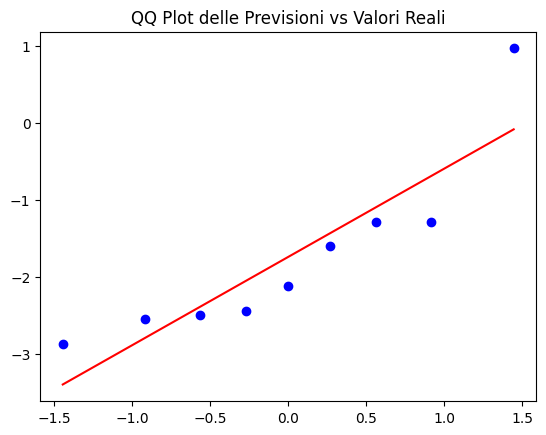

In [83]:
import matplotlib.pyplot as plt
import scipy.stats as stats

# Calcola i quantili dei valori predetti e dei valori reali
stats.probplot(xgb_predictions - y_test.values, dist="norm", plot=plt)

# Titolo e etichette
plt.title("QQ Plot delle Previsioni vs Valori Reali")
plt.xlabel("Quantili Teorici")
plt.ylabel("Quantili dei Residui")

# Mostra il plot
plt.show()
